In [1]:
# Load the required packages

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.applications import vgg16,MobileNetV2, ResNet50, Xception, inception_v3
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow as tf

from sklearn.metrics import accuracy_score,precision_score,recall_score,precision_recall_curve,PrecisionRecallDisplay
from sklearn.metrics import f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
import simplejson as json
import seaborn as sns
import pandas as pd
import numpy as np
import random
import json
import cv2
import os

## Data Pre- processing

In [2]:
# Load the required data folders

images=os.path.join("archive/Medical mask/Medical mask/Medical Mask/images")
annotations=os.path.join("archive/Medical mask/Medical mask/Medical Mask/annotations")
train=pd.read_csv(os.path.join("archive/train.csv"))
submission=pd.read_csv(os.path.join("archive/submission.csv"))
configFile = "facedetectionOpenCV-master/deploy.prototxt.txt"
modelFile = "facedetectionOpenCV-master/res10_300x300_ssd_iter_140000.caffemodel"
cvNet = cv2.dnn.readNetFromCaffe(configFile,modelFile)

In [3]:
train.count()

name         15412
x1           15412
x2           15412
y1           15412
y2           15412
classname    15412
dtype: int64

In [4]:
# Fucntion to load the .json annotations

def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

# Function to perform the gamma correction

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

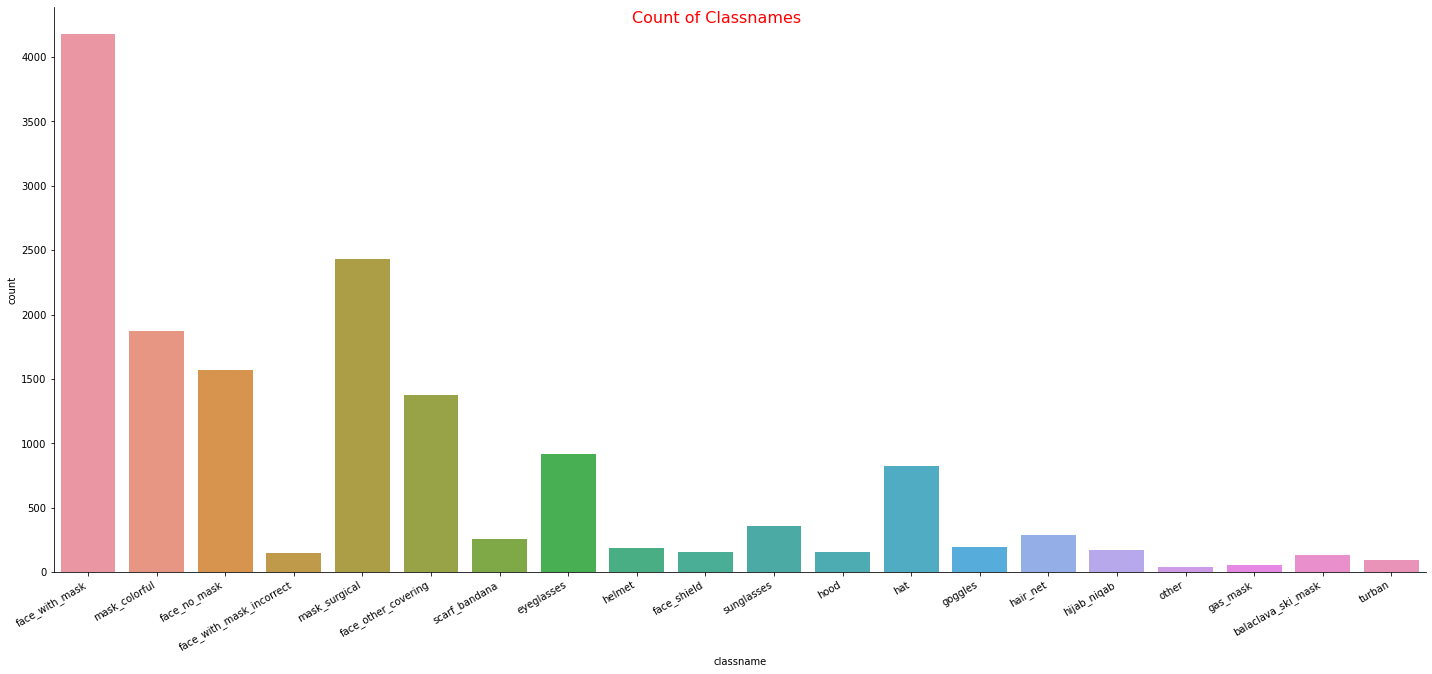

In [5]:
# Visualization of the entire data and classes in the dataset

ax = sns.catplot(x='classname',kind='count',data=train,orient="h",height=10,aspect=2)
ax.fig.suptitle('Count of Classnames',fontsize=16,color="r")
ax.fig.autofmt_xdate()

In [6]:
jsonfiles= []
for i in os.listdir(annotations):
    jsonfiles.append(getJSON(os.path.join(annotations,i)))
jsonfiles[0]

{'FileName': '5045.jpg',
 'NumOfAnno': 4,
 'Annotations': [{'isProtected': False,
   'ID': 516598418402004352,
   'BoundingBox': [1737, 339, 2062, 740],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 131128420050989904,
   'BoundingBox': [636, 207, 946, 634],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 944789222496780416,
   'BoundingBox': [677, 399, 929, 620],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 587553649932228096,
   'BoundingBox': [1812, 516, 2049, 722],
   'classname': 'mask_surgical',
   'Confidence': 1,
   'Attributes': {}}]}

In [7]:
train.head()

name   x1   x2   y1   y2       classname
0  2756.png   69  126  294  392  face_with_mask
1  2756.png  505   10  723  283  face_with_mask
2  2756.png   75  252  264  390   mask_colorful
3  2756.png  521  136  711  277   mask_colorful
4  6098.jpg  360   85  728  653    face_no_mask

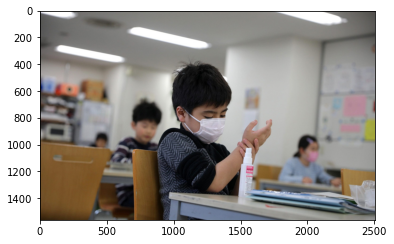

In [8]:
options = ['face_with_mask','face_no_mask']
train_new = train[train['classname'].isin(options)].sort_values('name')

train_images = train_new.name.unique().tolist()
test_images = submission.name.unique().tolist()

# pick a random index from train_images
i = np.random.choice(np.arange(1801, len(train_images)))
# read image
img = plt.imread(os.path.join(images,train_images[i]))
# plot image
plt.imshow(img)

In [9]:
# create a list that would contain bounding boxes for each face
bounding_box=[]
for i in range(len(train_new)):
    lst = []
    # extract coordinates of bounding box
    for box in train_new.iloc[i][["x1",'x2','y1','y2']]:
        lst.append(box)
    bounding_box.append(lst)
    
#add new column with bounding boxes
train_new["bounding_box"] = bounding_box  

# get box(es) for each unique image
def get_boxes(filename):
    boxes = []
    # get bounding_box column for all rows where train_new["name"] == filename
    for box in train_new[train_new["name"] == filename]["bounding_box"]:
        boxes.append(box)
    return boxes

[[419, 35, 845, 589]]


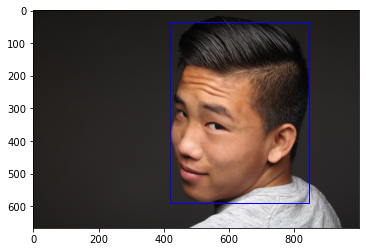

In [10]:
# draw an image with detected objects
def draw_facebox(image, boxes):
    # plot the image
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for box in boxes:
    # get coordinates
        x, y, width, height = box[0], box[1], box[2], box[3],
        # create the shape
        rect = plt.Rectangle((x, y), width-x, height-y, 
                             fill=False, color='b', linewidth=1)
        # draw the box
        ax.add_patch(rect)
    # show the plot
    plt.show()
    # pick a random index from train_images
i = np.random.choice(np.arange(1801, len(train_images)))
# read image
image = plt.imread(os.path.join(images,train_images[i]))
# get boxes for image
boxes = get_boxes(train_images[i])
print(boxes)
draw_facebox(image, boxes)

In [11]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in train["name"].unique():
    image_name = i
    f = i+".json"
    for j in getJSON(os.path.join(annotations,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(images,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([image_name,img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(images,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([image_name,img,labels["without mask"]])
random.shuffle(data)  

In [12]:
len(data)

5749

/Users/Gowri_1991/opt/anaconda3/envs/assignment/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

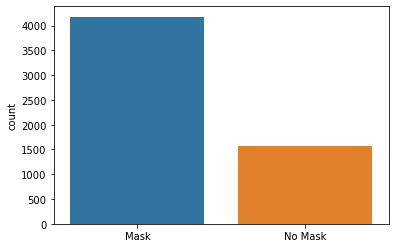

In [13]:
p = []
for face in data:
    if(face[2] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

In [14]:
X = []
Y = []
for image,features,label in data:
    X.append([image,features])
    Y.append(label)

X_sample_train,X_sample_val,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

train_images = []
validation_images = []
xval = []
xtrain = []
for row in X_sample_val:
    validation_images.append(row[0])
    xval.append(row[1])

for row in X_sample_train:
    train_images.append(row[0])
    xtrain.append(row[1])

validate_df = pd.DataFrame(data=validation_images,columns = ["name"])
validate_df = validate_df.sort_values(by=['name'])
validate_df = validate_df.reset_index(drop=True)

#Copy the train data to get the ground truth
train_modify = train
#train_modify.drop(['classname'],inplace=True,axis=1)
train_modify = train_modify.sort_values(by=['name'])
train_modify=train_modify.drop_duplicates(subset = ["name"])
train_modify['gt'] = train_modify[train_modify.columns[1:5]].apply(lambda x: x.tolist(),axis=1)

# Compare validate_df and train_modify and get only the ground truth for images in validate_df
train_temp = train_modify[['name','gt']]
validate_df = pd.merge(validate_df, train_temp, left_on="name", right_on="name", how="left")
validate_df.head()

name                    gt
0  1801.jpg  [451, 186, 895, 697]
1  1804.jpg  [127, 194, 243, 293]
2  1808.jpg   [3, 650, 338, 1374]
3  1810.jpg   [99, 212, 233, 373]
4  1812.jpg  [468, 123, 537, 194]

In [15]:
xtrain[0].shape

(124, 124, 3)

In [16]:
xtrain = np.array(xtrain)/255.0
xval = np.array(xval)/255.0
xtrain = xtrain.reshape(-1,124,124,3)
xval = xval.reshape(-1,124,124,3)
ytrain = np.array(ytrain).reshape((-1, 1))
yval = np.array(yval).reshape((-1, 1))

In [17]:
np.unique(ytrain)

array([0, 1])

In [18]:
ytrain.shape

(4599, 1)

In [19]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

## Evaluation Metrics

In [20]:
# Function to calculate mAP

def mAP_calculation(y_true, y_pred):
    precisions_1 = []
    recalls_1 = []
    precisions_0 = []
    recalls_0 = []

    precision_1 = precision_score(y_true=y_true, y_pred=y_pred, pos_label=1)
    recall_1 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=1)
    precision_0 = precision_score(y_true=y_true, y_pred=y_pred, pos_label=0)
    recall_0 = recall_score(y_true=y_true, y_pred=y_pred, pos_label=0)
        
    precisions_1.append(precision_1)
    precisions_1.append(1)
    recalls_1.append(recall_1)
    recalls_1.append(0)
    precisions_0.append(precision_0)
    precisions_0.append(1)
    recalls_0.append(recall_0)
    recalls_0.append(0)
    
    precisions_1 = np.array(precisions_1)
    recalls_1 = np.array(recalls_1)
    precisions_0 = np.array(precisions_0)
    recalls_0 = np.array(recalls_0)
    
    AP_1 = np.sum((recalls_1[:-1] - recalls_1[1:]) * precisions_1[:-1])
    AP_0 = np.sum((recalls_0[:-1] - recalls_0[1:]) * precisions_0[:-1])
    mAP = (AP_1 + AP_0) / 2
    
    return mAP

# Function to calculate accuracy, precision, recall, f1-score, ROC

def get_metrics(pred_class):
    pred = pred_class[:, 0]

    y_hat_array = []
    for i in range(len(pred)):
        if pred[i]> 0.5:
            y_hat_array.append([1])
        else:
            y_hat_array.append([0]) 
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(yval, y_hat_array)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(yval, y_hat_array)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(yval, y_hat_array)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(yval, y_hat_array)
    print('F1 score: %f' % f1)
    print("mAP for the model is : {}".format(mAP_calculation(yval, y_hat_array)))
 
    # kappa
    kappa = cohen_kappa_score(yval, y_hat_array)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(yval, y_hat_array)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(yval, y_hat_array)
    disp=ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.show()
    
    precision, recall, _ = precision_recall_curve(yval, y_hat_array)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.show()

## Models

## CNN-1

In [21]:
CNN_model = Sequential()
CNN_model.add(Conv2D(200, (3, 3), padding = "same", 
                     activation='relu', input_shape=(124,124,3)))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Conv2D(100, (3, 3), activation='relu'))
CNN_model.add(MaxPooling2D(pool_size=(2,2)))
CNN_model.add(Flatten())
CNN_model.add(Dropout(0.5))
CNN_model.add(Dense(50, activation='relu'))
CNN_model.add(Dense(1, activation='sigmoid'))

CNN_model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

CNN_history = CNN_model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

2021-12-08 15:35:09.925450: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Gowri_1991/opt/anaconda3/envs/assignment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-12-08 15:35:13.014692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
144/144 [==============================] - 311s 2s/step - loss: 0.7546 - accuracy: 0.7343 - val_loss: 0.3336 - val_accuracy: 0.8278
Epoch 2/10
144/144 [==============================] - 311s 2s/step - loss: 0.3292 - accuracy: 0.8606 - val_loss: 0.2888 - val_accuracy: 0.8730
Epoch 3/10
144/144 [==============================] - 325s 2s/step - loss: 0.2563 - accuracy: 0.8943 - val_loss: 0.2352 - val_accuracy: 0.9157
Epoch 4/10
144/144 [==============================] - 319s 2s/step - loss: 0.2490 - accuracy: 0.8947 - val_loss: 0.2272 - val_accuracy: 0.9217
Epoch 5/10
144/144 [==============================] - 327s 2s/step - loss: 0.2458 - accuracy: 0.9001 - val_loss: 0.2402 - val_accuracy: 0.9026
Epoch 6/10
144/144 [==============================] - 335s 2s/step - loss: 0.2265 - accuracy: 0.9042 - val_loss: 0.2223 - val_accuracy: 0.9209
Epoch 7/10
144/144 [==============================] - 330s 2s/step - loss: 0.2271 - accuracy: 0.9102 - val_loss: 0.1876 - val_accuracy: 0.9365

In [22]:
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 200)     5600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 100)       180100    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 90000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 90000)             0         
_________________________________________________________________
dense (Dense)                (None, 50)                4

Accuracy: 0.935652
Precision: 0.893939
Recall: 0.883234
F1 score: 0.888554
mAP for the model is : 0.8505720547459925
Cohens kappa: 0.843324
ROC AUC: 0.920171


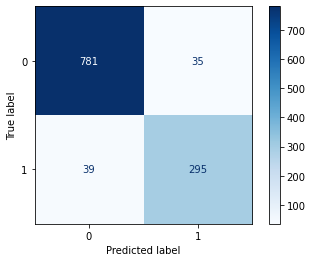

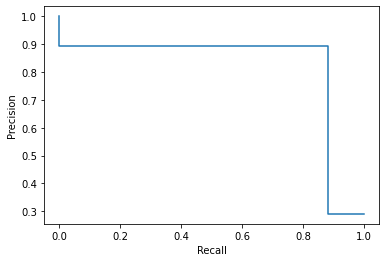

In [23]:
#Evaluation Metrics for CNN-1

pred_class = CNN_model.predict(xval, verbose =0 )
get_metrics(pred_class)

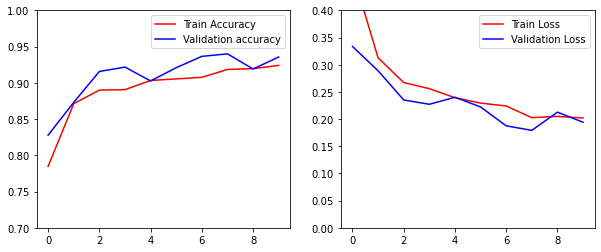

In [24]:
#Training Accuracy vs Validation Accuracy and Train Loss vs Validation Loss Plots

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(CNN_history.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(CNN_history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.ylim(0.7,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(CNN_history.history['loss'], label='Train Loss', color='red')
plt.plot(CNN_history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(0,0.4)
plt.legend()

plt.show()

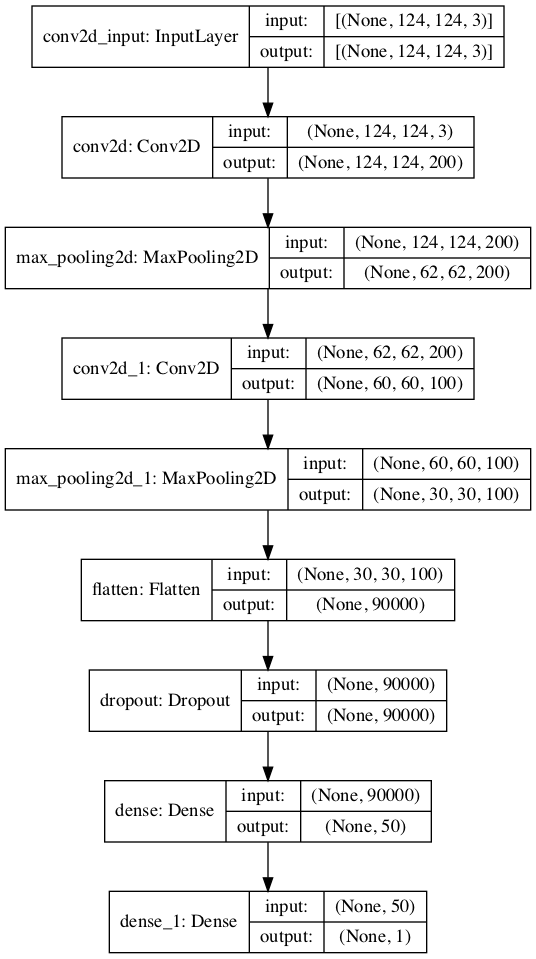

In [25]:
plot_model(CNN_model, show_shapes=True, to_file='updated_.png')

## CNN-2

In [26]:
CNN_model_2 = Sequential()

CNN_model_2.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))
CNN_model_2.add(Conv2D(64, (3, 3), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))
CNN_model_2.add(Conv2D(128, (3, 3), activation='relu'))
CNN_model_2.add(MaxPooling2D(pool_size=(2,2)))
CNN_model_2.add(Dropout(0.25))
 
CNN_model_2.add(Flatten())
CNN_model_2.add(Dropout(0.5))
CNN_model_2.add(Dense(50, activation='relu'))
CNN_model_2.add(Dropout(0.5))
CNN_model_2.add(Dense(1, activation='sigmoid'))

CNN_model_2.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

CNN_model_2.summary()

CNN_history_2 = CNN_model_2.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 124, 124, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)      

/Users/Gowri_1991/opt/anaconda3/envs/assignment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
144/144 [==============================] - 58s 388ms/step - loss: 0.4157 - accuracy: 0.8019 - val_loss: 0.2469 - val_accuracy: 0.9009
Epoch 2/10
144/144 [==============================] - 55s 384ms/step - loss: 0.2824 - accuracy: 0.8702 - val_loss: 0.2353 - val_accuracy: 0.9070
Epoch 3/10
144/144 [==============================] - 54s 374ms/step - loss: 0.2492 - accuracy: 0.8931 - val_loss: 0.2475 - val_accuracy: 0.9104
Epoch 4/10
144/144 [==============================] - 52s 357ms/step - loss: 0.2477 - accuracy: 0.8926 - val_loss: 0.2166 - val_accuracy: 0.9200
Epoch 5/10
144/144 [==============================] - 54s 377ms/step - loss: 0.2557 - accuracy: 0.8966 - val_loss: 0.2018 - val_accuracy: 0.9235
Epoch 6/10
144/144 [==============================] - 52s 358ms/step - loss: 0.2042 - accuracy: 0.9173 - val_loss: 0.2012 - val_accuracy: 0.9226
Epoch 7/10
144/144 [==============================] - 52s 360ms/step - loss: 0.2128 - accuracy: 0.9134 - val_loss: 0.1989 - val_ac

Accuracy: 0.928696
Precision: 0.857955
Recall: 0.904192
F1 score: 0.880466
mAP for the model is : 0.838418835168177
Cohens kappa: 0.829711
ROC AUC: 0.921459


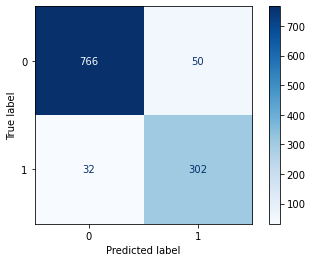

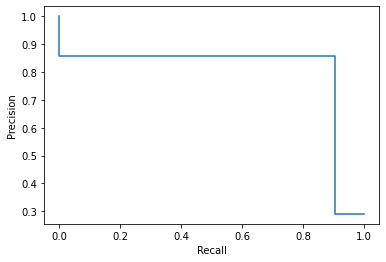

In [27]:
pred_class = CNN_model_2.predict(xval, verbose =0 )
get_metrics(pred_class)

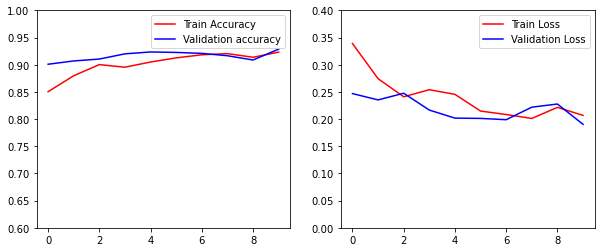

In [28]:
#Training Accuracy vs Validation Accuracy and Train Loss vs Validation Loss Plots

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(CNN_history_2.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(CNN_history_2.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.ylim(0.6,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(CNN_history_2.history['loss'], label='Train Loss', color='red')
plt.plot(CNN_history_2.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(0,0.4)
plt.legend()

plt.show()

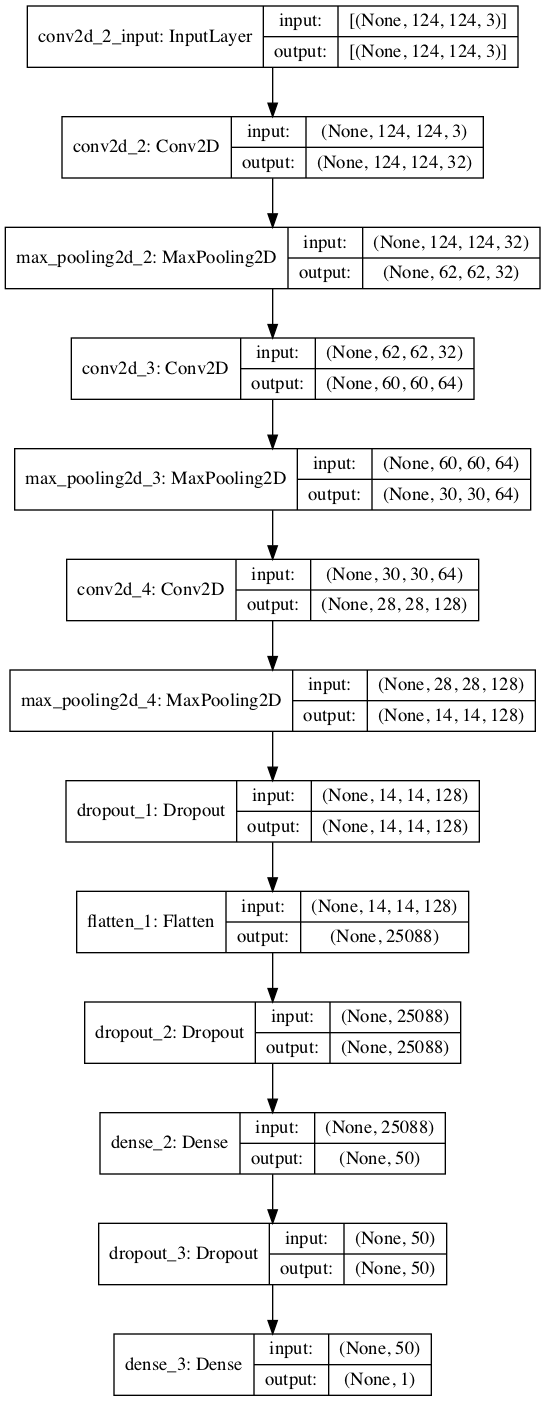

In [29]:
plot_model(CNN_model_2, show_shapes=True, to_file='updated_.png')

## VGG-16

In [34]:
# Specify network architecture
new_input = Input(shape=(124, 124, 3))
vgg16_model = vgg16.VGG16(include_top=False, input_tensor=new_input)

for layer in vgg16_model.layers:
    layer.trainable = False # Freeze parameters of VGG16
    
flatten = Flatten()(vgg16_model.layers[-1].output)
dense = Dense(1024, activation='relu')(flatten)
output = Dense(1, activation='sigmoid')(dense)
VGG_model = Model(inputs=vgg16_model.inputs, outputs=output)

opt = optimizers.Adam(learning_rate=0.001)
VGG_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
VGG_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124, 124, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 124, 124, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 124, 124, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0     

In [35]:
# train the model
VGG_history = VGG_model.fit(xtrain, ytrain, batch_size=32, epochs=10, validation_data=(xval, yval))

Epoch 1/10
144/144 [==============================] - 490s 3s/step - loss: 0.4739 - acc: 0.8451 - val_loss: 0.1711 - val_acc: 0.9313
Epoch 2/10
144/144 [==============================] - 488s 3s/step - loss: 0.1099 - acc: 0.9531 - val_loss: 0.1708 - val_acc: 0.9270
Epoch 3/10
144/144 [==============================] - 492s 3s/step - loss: 0.0881 - acc: 0.9646 - val_loss: 0.1839 - val_acc: 0.9270
Epoch 4/10
144/144 [==============================] - 486s 3s/step - loss: 0.0677 - acc: 0.9713 - val_loss: 0.1745 - val_acc: 0.9400
Epoch 5/10
144/144 [==============================] - 483s 3s/step - loss: 0.0565 - acc: 0.9765 - val_loss: 0.2378 - val_acc: 0.9270
Epoch 6/10
144/144 [==============================] - 495s 3s/step - loss: 0.0554 - acc: 0.9747 - val_loss: 0.2290 - val_acc: 0.9287
Epoch 7/10
144/144 [==============================] - 510s 4s/step - loss: 0.0362 - acc: 0.9862 - val_loss: 0.2475 - val_acc: 0.9339
Epoch 8/10
144/144 [==============================] - 510s 4s/step - 

Accuracy: 0.928696
Precision: 0.942748
Recall: 0.786624
F1 score: 0.857639
mAP for the model is : 0.8247746044019792
Cohens kappa: 0.810591
ROC AUC: 0.884341


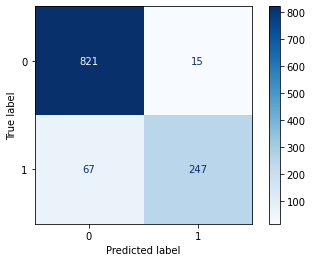

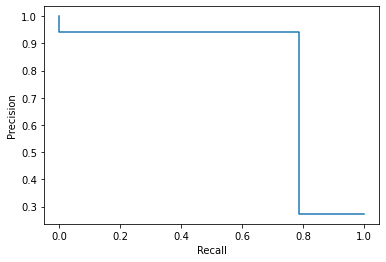

In [36]:
pred_class = VGG_model.predict(xval, verbose =0 )
get_metrics(pred_class)

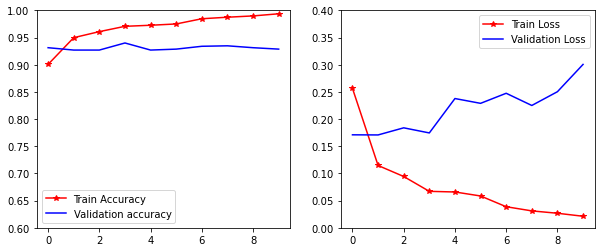

In [37]:
#Training Accuracy vs Validation Accuracy and Train Loss vs Validation Loss Plots
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(VGG_history.history['acc'], label='Train Accuracy', color='red', marker='*')
plt.plot(VGG_history.history['val_acc'], label='Validation accuracy', color='blue')
plt.ylim(0.6,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(VGG_history.history['loss'], label='Train Loss', color='red', marker='*')
plt.plot(VGG_history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(0,0.4)
plt.legend()

plt.show()

## ResNet50

In [30]:
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=Input(shape=(124, 124, 3)),pooling='avg')

# don't train existing weights
for layer in base_model.layers:
    layer.trainable = False

headModel = Flatten()(base_model.output)
headModel = BatchNormalization() (headModel)

headModel = Dense(1024, activation='relu') (headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(256, activation='relu') (headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation='sigmoid')(headModel)

Resnet_model = Model(inputs=base_model.input, outputs=headModel)

opt = Adam(learning_rate=0.001, decay=0.01)
Resnet_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
Resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 124, 124, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 130, 130, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 62, 62, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 62, 62, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [31]:
Resnet_history = Resnet_model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/10
143/143 [==============================] - 187s 1s/step - loss: 0.5575 - accuracy: 0.7178 - val_loss: 0.5734 - val_accuracy: 0.7096
Epoch 2/10
143/143 [==============================] - 171s 1s/step - loss: 0.5158 - accuracy: 0.7334 - val_loss: 0.5337 - val_accuracy: 0.7096
Epoch 3/10
143/143 [==============================] - 173s 1s/step - loss: 0.5079 - accuracy: 0.7304 - val_loss: 0.5131 - val_accuracy: 0.7200
Epoch 4/10
143/143 [==============================] - 166s 1s/step - loss: 0.4928 - accuracy: 0.7534 - val_loss: 0.4874 - val_accuracy: 0.7496
Epoch 5/10
143/143 [==============================] - 164s 1s/step - loss: 0.4825 - accuracy: 0.7600 - val_loss: 0.4706 - val_accuracy: 0.7670
Epoch 6/10
143/143 [==============================] - 164s 1s/step - loss: 0.4767 - accuracy: 0.7476 - val_loss: 0.4669 - val_accuracy: 0.7661
Epoch 7/10
143/143 [==============================] - 159s 1s/step - loss: 0.4797 - accuracy: 0.7612 - val_loss: 0.4654 - val_accuracy: 0.7739

In [32]:
# evaluate model
_, acc = Resnet_model.evaluate(xval, yval, verbose=0)
print('Test Loss > %.3f' % _)
print('Test Accuracy > %.3f' % (acc * 100.0))

Test Loss > 0.457
Test Accuracy > 77.217


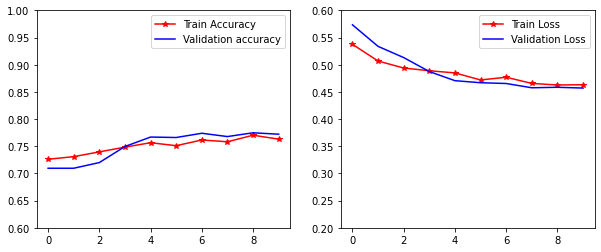

In [33]:
#Training Accuracy vs Validation Accuracy and Train Loss vs Validation Loss Plots

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(Resnet_history.history['accuracy'], label='Train Accuracy', color='red', marker='*')
plt.plot(Resnet_history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.ylim(0.6,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(Resnet_history.history['loss'], label='Train Loss', color='red', marker='*')
plt.plot(Resnet_history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(0.2,0.6)
plt.legend()

plt.show()


Accuracy: 0.780870
Precision: 0.639640
Recall: 0.452229
F1 score: 0.529851
mAP for the model is : 0.5129807628629979
Cohens kappa: 0.392432
ROC AUC: 0.678268


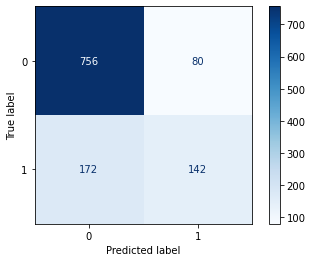

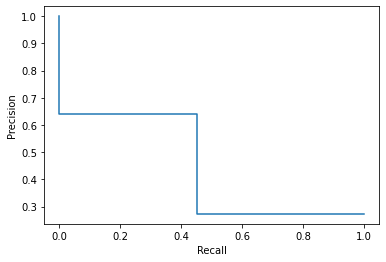

In [51]:
pred_class = Resnet_model.predict(xval, verbose =0 )
get_metrics(pred_class)

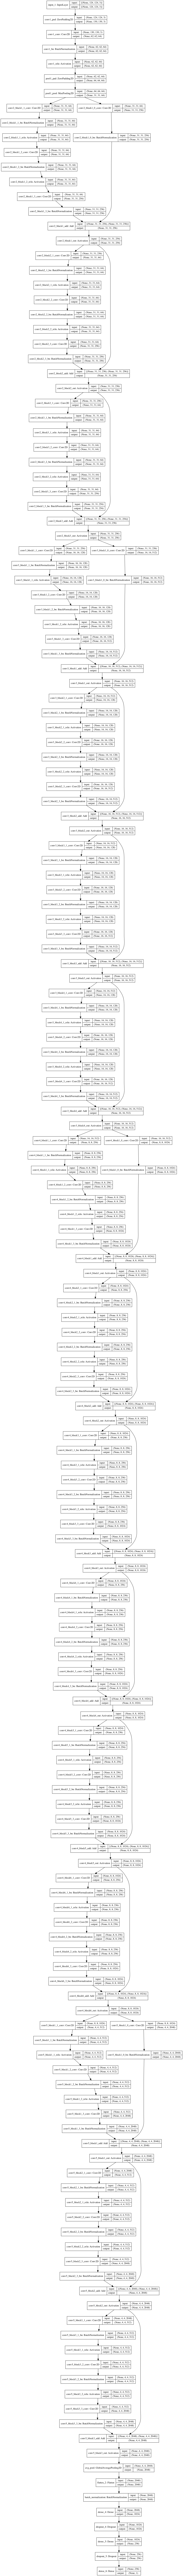

In [34]:
plot_model(Resnet_model,show_shapes=True,to_file='resnet50.png')

## Inception

In [55]:
incep = inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(124, 124, 3)),pooling='avg')

# don't train existing weights
for layer in incep.layers:
    layer.trainable = False

headModel = Flatten()(incep.output)
headModel = Dense(1024, activation='relu') (headModel)
headModel = Dropout(0.5)(headModel)

#headModel = BatchNormalization() (headModel)
headModel = Dense(256, activation='relu') (headModel)
headModel = Dropout(0.5)(headModel)

headModel = Dense(1, activation='sigmoid')(headModel)

Inception_model = Model(inputs=incep.input, outputs=headModel)

opt = Adam(learning_rate=0.001, decay=0.01)

Inception_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
Inception_model.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 124, 124, 3) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 61, 61, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 61, 61, 32)   96          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 61, 61, 32)   0           batch_normalization_1[0][0]      
___________________________

In [56]:
Inception_history = Inception_model.fit(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/10
143/143 [==============================] - 108s 730ms/step - loss: 0.7684 - accuracy: 0.8050 - val_loss: 0.2038 - val_accuracy: 0.9191
Epoch 2/10
143/143 [==============================] - 101s 706ms/step - loss: 0.2414 - accuracy: 0.9017 - val_loss: 0.2029 - val_accuracy: 0.9174
Epoch 3/10
143/143 [==============================] - 99s 690ms/step - loss: 0.2142 - accuracy: 0.9144 - val_loss: 0.1935 - val_accuracy: 0.9243
Epoch 4/10
143/143 [==============================] - 97s 679ms/step - loss: 0.2027 - accuracy: 0.9202 - val_loss: 0.1861 - val_accuracy: 0.9278
Epoch 5/10
143/143 [==============================] - 97s 677ms/step - loss: 0.2019 - accuracy: 0.9195 - val_loss: 0.1809 - val_accuracy: 0.9261
Epoch 6/10
143/143 [==============================] - 97s 679ms/step - loss: 0.1762 - accuracy: 0.9313 - val_loss: 0.1802 - val_accuracy: 0.9287
Epoch 7/10
143/143 [==============================] - 99s 692ms/step - loss: 0.1625 - accuracy: 0.9345 - val_loss: 0.1766 - val_

In [57]:
# evaluate model
_, acc = Inception_model.evaluate(xval, yval, verbose=0)
print('Test Loss > %.3f' % _)
print('Test Accuracy > %.3f' % (acc * 100.0))

Test Loss > 0.167
Test Accuracy > 93.652


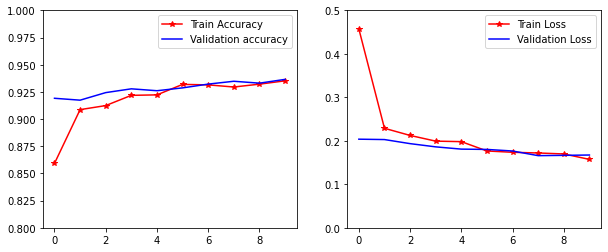

In [75]:
#Training Accuracy vs Validation Accuracy and Train Loss vs Validation Loss Plots

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(Inception_history.history['accuracy'], label='Train Accuracy', color='red', marker='*')
plt.plot(Inception_history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.ylim(0.8,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(Inception_history.history['loss'], label='Train Loss', color='red', marker='*')
plt.plot(Inception_history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(0,0.5)
plt.legend()

plt.show()

Accuracy: 0.936522
Precision: 0.961686
Recall: 0.799363
F1 score: 0.873043
mAP for the model is : 0.8433779685817322
Cohens kappa: 0.831203
ROC AUC: 0.893701


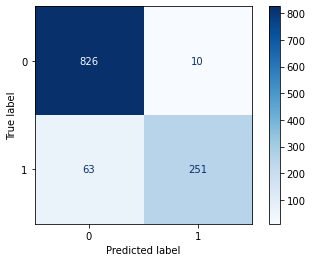

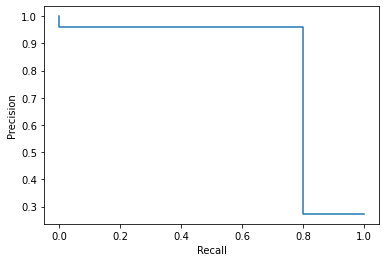

In [61]:
pred_class = Inception_model.predict(xval, verbose =0 )
get_metrics(pred_class)

## Xception

In [63]:
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(124, 124, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
Xception_model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process

for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(learning_rate=0.001, decay=0.01)

Xception_model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
Xception_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 124, 124, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 61, 61, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 61, 61, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 61, 61, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [64]:
Xception_history = Xception_model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=10,
                    verbose=1,
                    validation_data=(xval, yval))

/Users/Gowri_1991/opt/anaconda3/envs/assignment/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
143/143 [==============================] - 235s 2s/step - loss: 0.2420 - accuracy: 0.8879 - val_loss: 0.1458 - val_accuracy: 0.9478
Epoch 2/10
143/143 [==============================] - 234s 2s/step - loss: 0.1215 - accuracy: 0.9543 - val_loss: 0.1460 - val_accuracy: 0.9504
Epoch 3/10
143/143 [==============================] - 229s 2s/step - loss: 0.1118 - accuracy: 0.9519 - val_loss: 0.1347 - val_accuracy: 0.9496
Epoch 4/10
143/143 [==============================] - 235s 2s/step - loss: 0.1109 - accuracy: 0.9546 - val_loss: 0.1373 - val_accuracy: 0.9487
Epoch 5/10
143/143 [==============================] - 232s 2s/step - loss: 0.1035 - accuracy: 0.9556 - val_loss: 0.1400 - val_accuracy: 0.9530
Epoch 6/10
143/143 [==============================] - 220s 2s/step - loss: 0.1005 - accuracy: 0.9585 - val_loss: 0.1355 - val_accuracy: 0.9530
Epoch 7/10
143/143 [==============================] - 193s 1s/step - loss: 0.0956 - accuracy: 0.9645 - val_loss: 0.1363 - val_accuracy: 0.9496

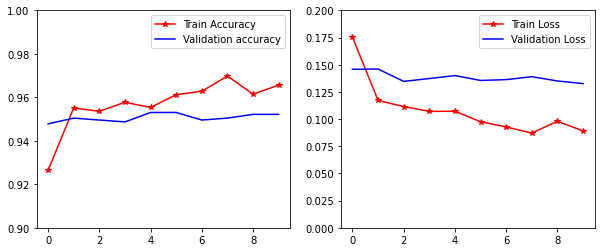

In [73]:
#Training Accuracy vs Validation Accuracy and Train Loss vs Validation Loss Plots

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)

plt.plot(Xception_history.history['accuracy'], label='Train Accuracy', color='red', marker='*')
plt.plot(Xception_history.history['val_accuracy'], label='Validation accuracy', color='blue')
plt.ylim(0.9,1)
plt.legend()

plt.subplot(1,2,2)
plt.plot(Xception_history.history['loss'], label='Train Loss', color='red', marker='*')
plt.plot(Xception_history.history['val_loss'], label='Validation Loss', color='blue')
plt.ylim(0,0.2)
plt.legend()

plt.show()



Accuracy: 0.952174
Precision: 0.954386
Recall: 0.866242
F1 score: 0.908180
mAP for the model is : 0.8816895657396937
Cohens kappa: 0.875949
ROC AUC: 0.925346


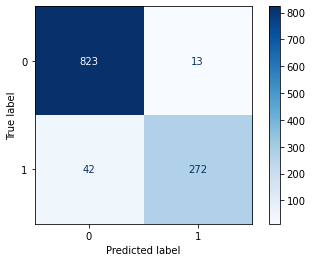

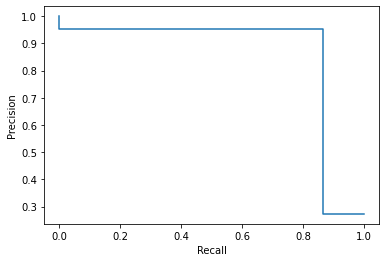

In [82]:
pred_class = Xception_model.predict(xval, verbose =0 )
get_metrics(pred_class)

## Saving the Xception model 

### The model's performance was higher when compared to other models experimented for face mask detection binary classification

In [83]:
# serialize the model to disk
Xception_model.save("face_mask_detector.model", save_format="h5")

## IOU evaluation metric

### We want to understand the working of calculation of IOU metric hence we tried implemention IOU for the pre-trained FaceNet model used to identify the faces in the images provided in the dataset

In [84]:
# Function to determine IOU for each image

def bb_intersection_over_union(gt_box, pred_box):
    inter_box_top_left = [max(gt_box[0], pred_box[0]), max(gt_box[1], pred_box[1])]
    inter_box_bottom_right = [min(gt_box[0]+gt_box[2], pred_box[0]+pred_box[2]), min(gt_box[1]+gt_box[3], pred_box[1]+pred_box[3])]

    inter_box_w = inter_box_bottom_right[0] - inter_box_top_left[0]
    inter_box_h = inter_box_bottom_right[1] - inter_box_top_left[1]

    intersection = inter_box_w * inter_box_h
    union = gt_box[2] * gt_box[3] + pred_box[2] * pred_box[3] - intersection
    
    iou = intersection / union

    return iou

def draw_facebox(image, gt_box,pred_box):
    # plot the image
    plt.imshow(image)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    # get coordinates
    x, y, width, height = gt_box[0], gt_box[1], gt_box[2], gt_box[3]
    px,py,pwidth,pheight = pred_box[0], pred_box[1], pred_box[2], pred_box[3]
        # create the shape
    rect = plt.Rectangle((x, y), width-x, height-y, 
                             fill=False, color='b', linewidth=8)
    rect2 = plt.Rectangle((px, py), pwidth-px, pheight-py, 
                             fill=False, color='g', linewidth=8)
        # draw the box
    ax.add_patch(rect)
    ax.add_patch(rect2)
    # show the plot
    plt.show()
    


In [161]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
i = np.random.choice(len(validate_df))
test_image = validate_df.iloc[i]["name"]
image =  cv2.imread(os.path.join(images,test_image),1)
image =  adjust_gamma(image, gamma=gamma)
(h, w) = image.shape[:2]
blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
cvNet.setInput(blob)
detections = cvNet.forward()
for i in range(0, detections.shape[2]):
    try:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        break
    except:pass

pred_box = [startX, startY, endX, endY]
gt_box = validate_df.iloc[i]["gt"]

iou = bb_intersection_over_union(gt_box, pred_box)
print("The IOU value is : {}".format(iou))

The IOU value is : 0.4419399706222621


<Figure size 1008x1008 with 0 Axes>

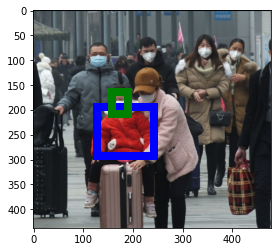

In [162]:
image = plt.imread(os.path.join(images,test_image))
draw_facebox(image, gt_box,pred_box)


## Testing

### Step-1: Load the saved model
### Step-2: Load some random test images given in the dataset
### Step-3: Identify the faces using the pre-trained model
### Step-4: Predict the images using the saved model
### Step-5: Draw bounding boxes with the class type around the faces identified
### Step-6: Display the images with results

In [163]:
# load the face mask detector model from disk
face_maskNet = load_model("face_mask_detector.model")

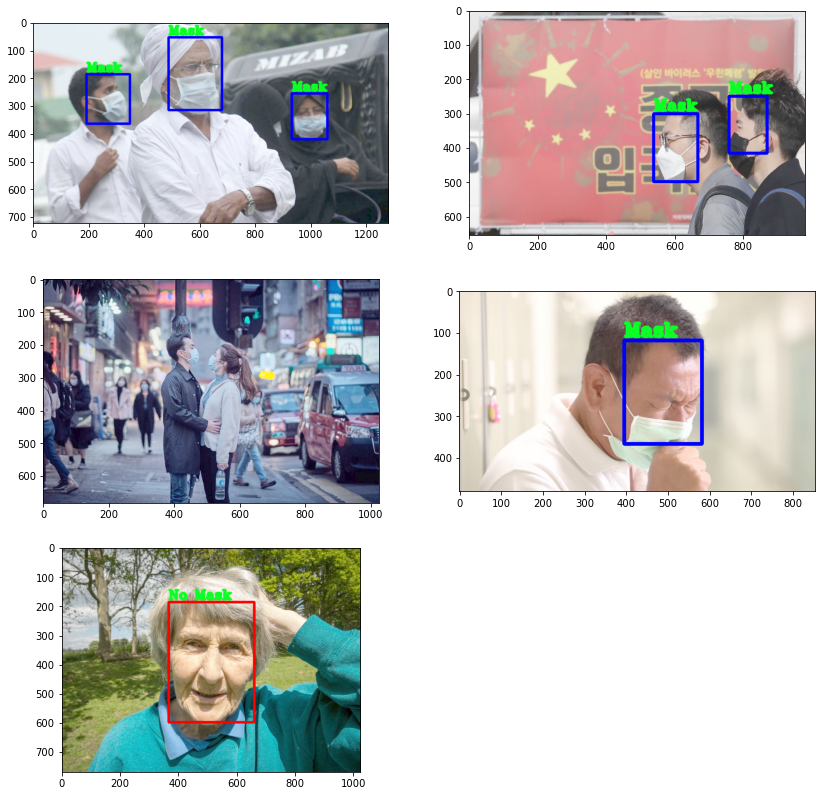

In [168]:
comp_test_images = list(submission["name"].unique())
test_images = []

for i in range(5):
    test_images.append(random.choice(comp_test_images))

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(images,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(-1,124,124,3)
                result = face_maskNet.predict(im) # Predicting the class using the saved model
                if result>0.5:
                    label_Y = 1
                    cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 8)
                    cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (36,255,12), 8)
                else:
                    label_Y = 0
                    cv2.rectangle(image, (startX, startY), (endX, endY), (255, 0, 0), 8)
                    cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_TRIPLEX, 1.5, (36,255,12), 8)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

